# Burgers equation

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html

In [5]:
import numpy as np

In [6]:
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




In [9]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [10]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [11]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)


In [12]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2540, num_boundary=80, num_initial=160)


In [13]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")


In [14]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)


Compiling model...
Building feed-forward neural network...
'build' took 0.059853 s



/home/x/miniconda3/envs/tf/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.240551 s



In [15]:
osshistory, train_state = model.train(iterations=1500)


Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.06e-01, 1.05e-01, 6.28e-01]    [3.06e-01, 1.05e-01, 6.28e-01]    []  
1000      [4.74e-02, 3.54e-03, 6.95e-02]    [4.74e-02, 3.54e-03, 6.95e-02]    []  
1500      [4.04e-02, 6.85e-04, 5.26e-02]    [4.04e-02, 6.85e-04, 5.26e-02]    []  

Best model at step 1500:
  train loss: 9.37e-02
  test loss: 9.37e-02
  test metric: []

'train' took 16.190589 s



In [16]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()


Compiling model...
'compile' took 0.246229 s

Training model...

Step      Train loss                        Test loss                         Test metric
1500      [4.04e-02, 6.85e-04, 5.26e-02]    [4.04e-02, 6.85e-04, 5.26e-02]    []  
2000      [6.34e-03, 7.14e-06, 9.36e-03]    [6.34e-03, 7.14e-06, 9.36e-03]        
3000      [5.13e-04, 4.68e-06, 1.77e-04]    [5.13e-04, 4.68e-06, 1.77e-04]        
4000      [2.39e-04, 6.65e-07, 7.36e-05]    [2.39e-04, 6.65e-07, 7.36e-05]        
5000      [1.30e-04, 4.61e-07, 5.31e-05]    [1.30e-04, 4.61e-07, 5.31e-05]        
6000      [7.62e-05, 2.22e-07, 2.54e-05]    [7.62e-05, 2.22e-07, 2.54e-05]        
7000      [4.46e-05, 8.37e-08, 1.35e-05]    [4.46e-05, 8.37e-08, 1.35e-05]        
8000      [2.79e-05, 9.31e-08, 6.08e-06]    [2.79e-05, 9.31e-08, 6.08e-06]        
9000      [1.89e-05, 1.31e-07, 1.80e-06]    [1.89e-05, 1.31e-07, 1.80e-06]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*

Saving loss history to /home/x/jlab/loss.dat ...
Saving training data to /home/x/jlab/train.dat ...
Saving test data to /home/x/jlab/test.dat ...


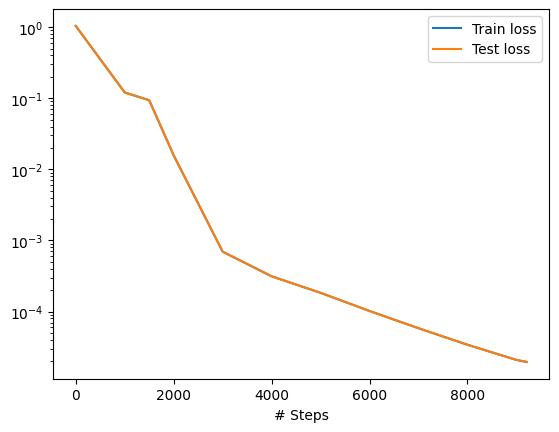

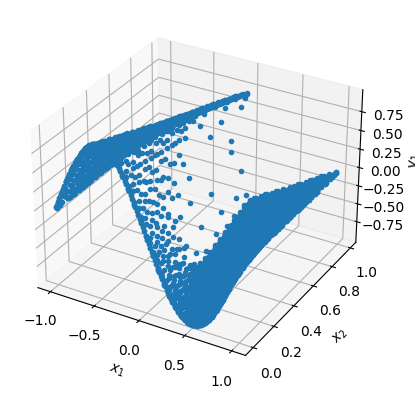

Mean residual: 0.0048597767
L2 relative error: 0.01587069098592641


In [17]:
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))
